In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import shap
shap.initjs()

In [82]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Datasets input

In [7]:
iris = datasets.load_iris()

In [8]:
data=pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'species':iris.target
})
data.head()

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [9]:
X=data[['sepal length', 'sepal width', 'petal length', 'petal width']]  # Features
y=data['species']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Random parameter tuning

In [68]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [73]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [83]:
print(rf_random.best_params_)
evaluate(rf_random, X_test, y_test)

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Model Performance
Average Error: 0.1111 degrees.
Accuracy = 90.00%.


90.0

# Grid search - Cross validation

In [84]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [25, 30, 35, 40],
    'max_features': [2,3,4],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [3,5,7],
    'n_estimators': [300, 400, 500]
}


In [85]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [86]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
{'bootstrap': True, 'max_depth': 25, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 400}
Model Performance
Average Error: 0.1111 degrees.
Accuracy = 90.00%.


In [24]:
clf=RandomForestClassifier(n_estimators=50,max_depth = 3,criterion="entropy")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [75]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
metrics.confusion_matrix(y_test,y_pred)

Accuracy: 0.8888888888888888


array([[15,  0,  0],
       [ 0,  9,  1],
       [ 0,  4, 16]])

In [27]:
feature_imp = pd.Series(clf.feature_importances_,index=iris.feature_names).sort_values(ascending=False)
feature_imp

petal width (cm)     0.580078
petal length (cm)    0.329318
sepal length (cm)    0.080286
sepal width (cm)     0.010317
dtype: float64

In [125]:
explainer = shap.Explainer(clf)

In [126]:
shap_values = explainer.shap_values(X_test)

In [128]:
shap.force_plot(explainer.expected_value[2],shap_values[2][0,:])

In [129]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

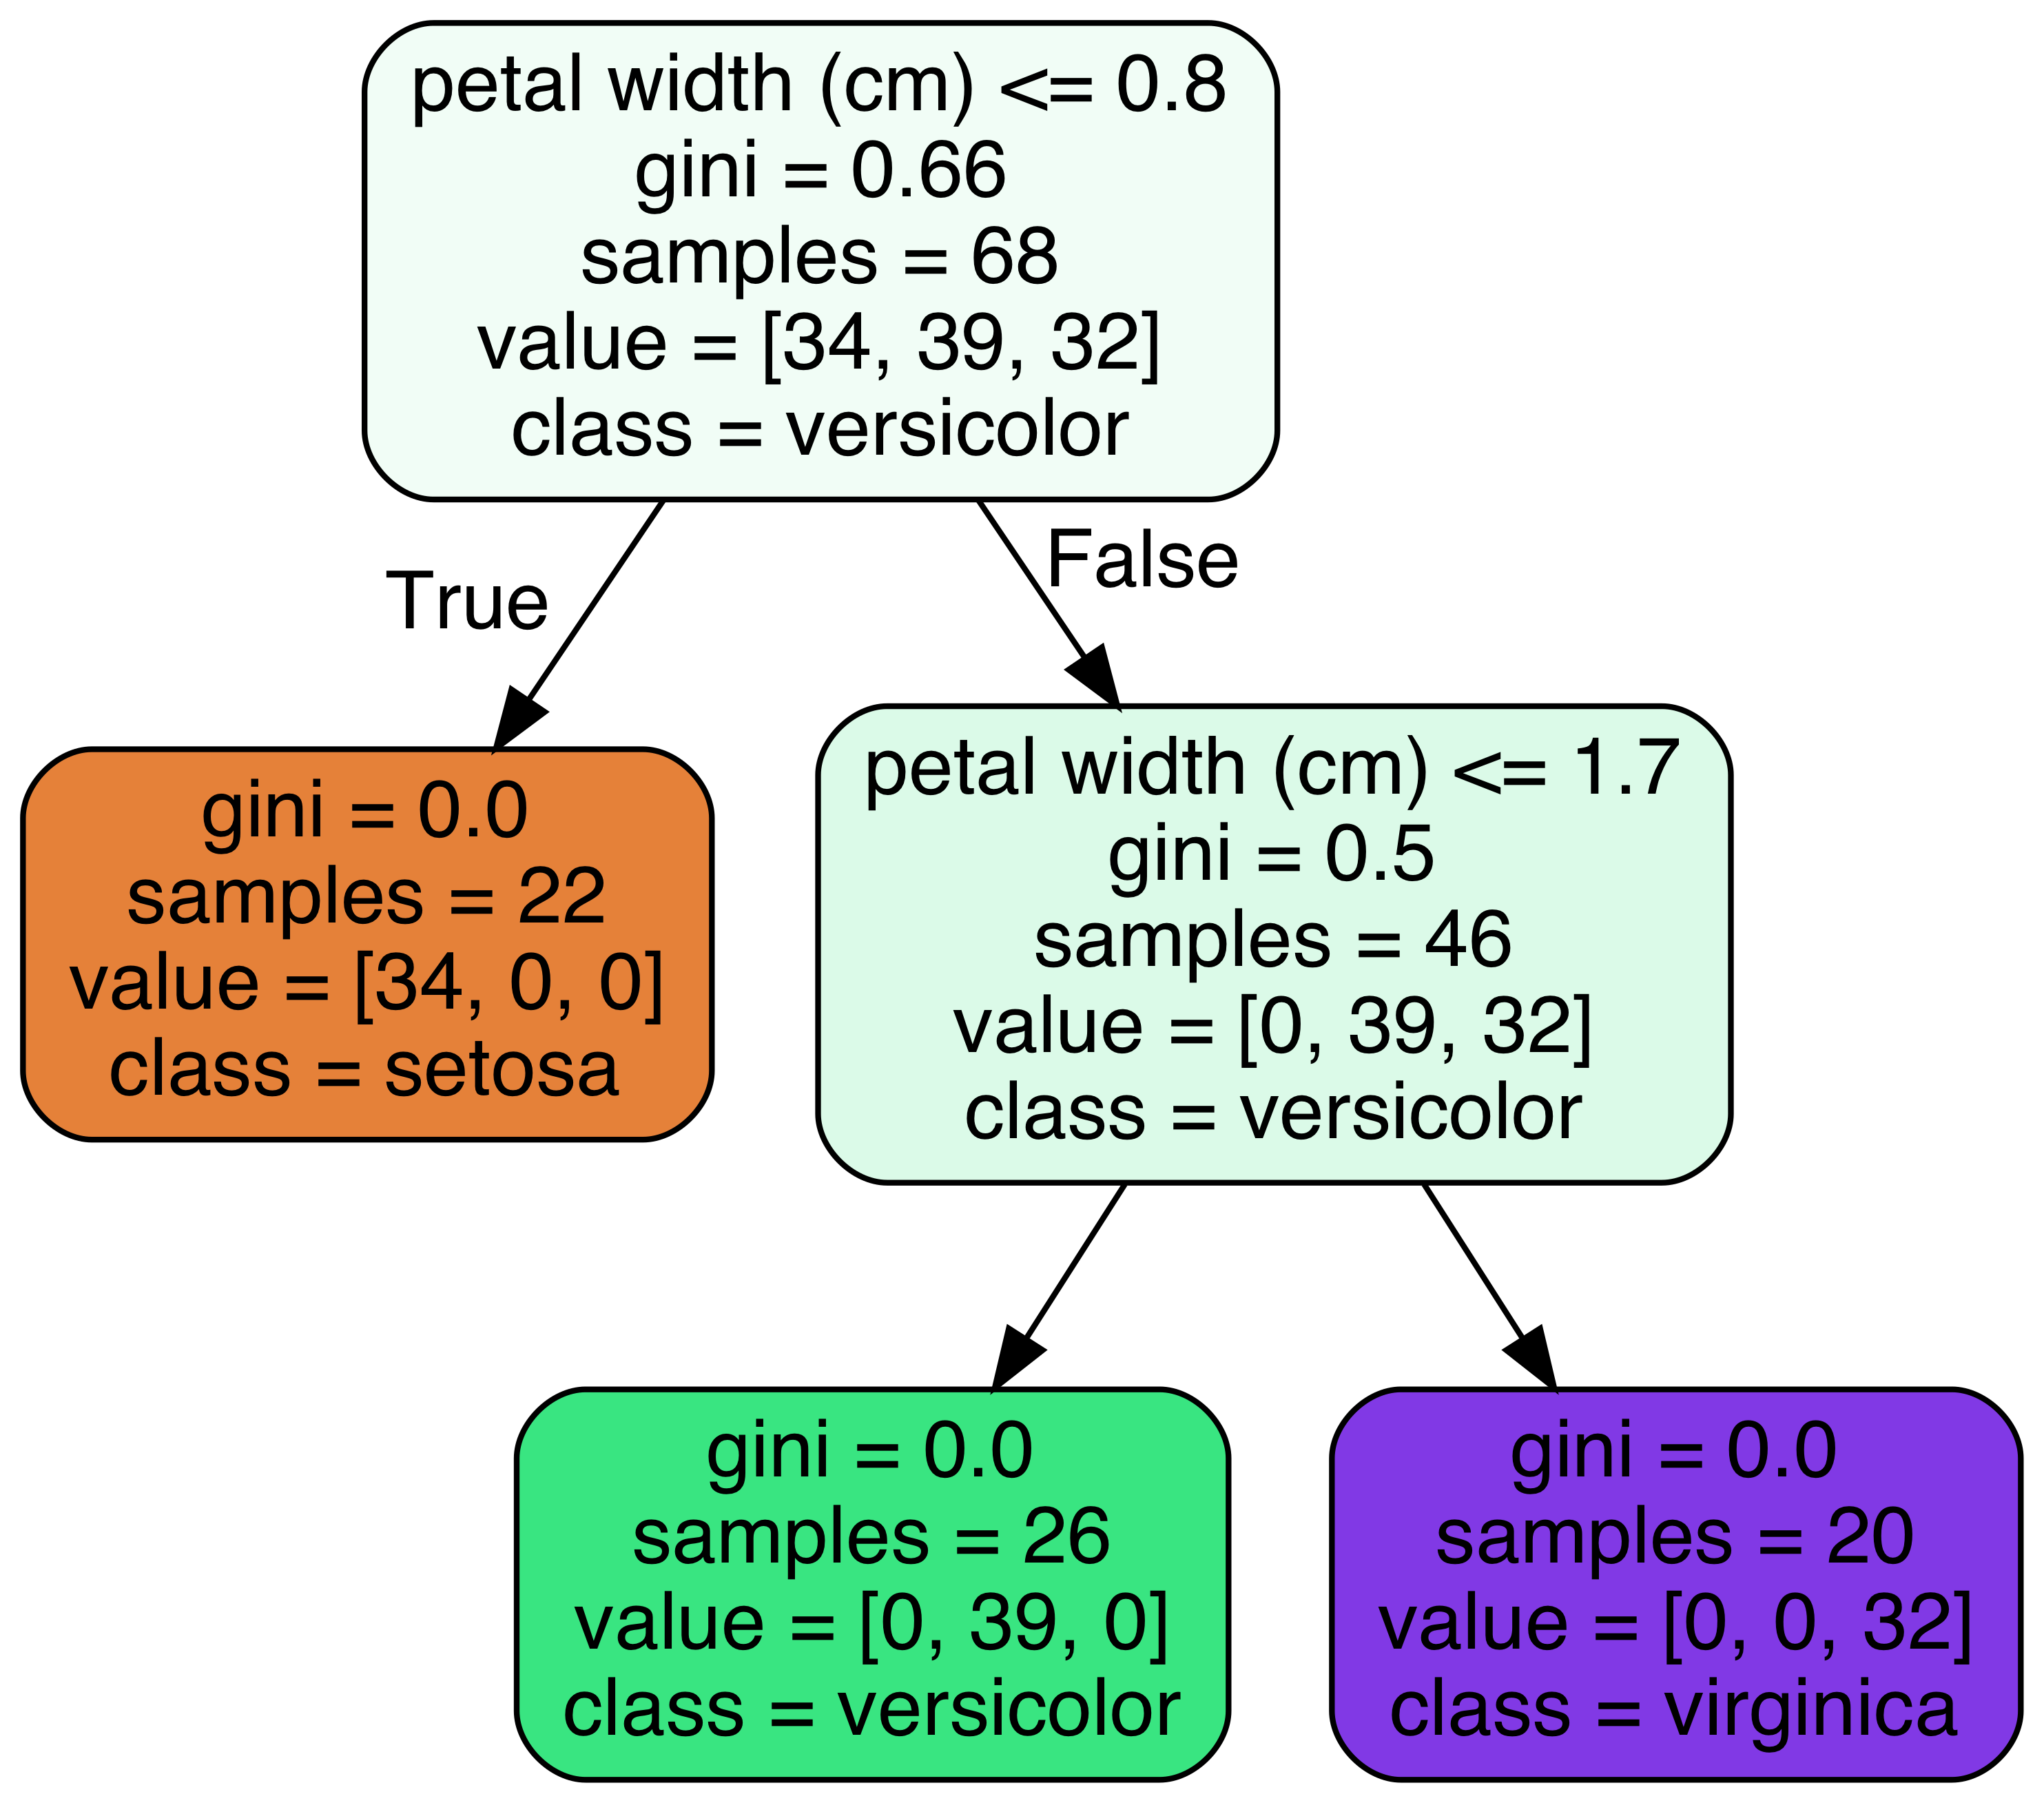

In [98]:

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(grid_search.best_estimator_.estimators_[5], out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [115]:
pred = grid_search.best_estimator_.predict(X_train)

In [116]:
metrics.confusion_matrix(pred,y_train)

array([[35,  0,  0],
       [ 0, 40,  0],
       [ 0,  0, 30]])